# Predição da Evapotranspiração

## Importação das bibliotecas utilizadas

In [55]:
# Importando os módulos
import csv
import pandas as pd
import matplotlib.pyplot as plt    
import numpy as np  
from sklearn.linear_model import LinearRegression
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from datetime import datetime, date, time, timezone
import matplotlib.pyplot as plt
%matplotlib inline 

## Importação dos dados

In [2]:
df_data = pd.read_csv('../dados/dataset.csv')
df_data.head()

,TIMESTAMP,RECORD,BP_mbar_Max,BP_mbar_Min,Rain_mm_Tot,AirTC_Max,AirTC_Min,RH_Max,RH_Min,SlrkJ_Tot,TdC_Max,TdC_Min,AirTC_Avg,RH_Avg,WS_ms_Avg,SlrkJ_Avg,Eto
0,2015-02-24 22:00:00,13253,600.8486,600.3632,0.000,23.472,23.341,99.998,99.998,0.193834,23.472,23.341,23.39763,99.99786,0.000000,0.000538,0.0002984148
1,2015-02-24 23:00:00,13254,600.7875,600.4396,0.000,23.472,23.26,99.998,99.998,0.137363,23.472,23.260,23.3635,99.99786,0.000000,0.000382,0.0002987745
2,2015-02-25 00:00:00,13255,601.1295,600.7021,0.254,23.371,23.212,99.998,99.998,0.137363,23.371,23.212,23.29213,99.99786,0.002500,0.000382,0.0002994588
3,2015-02-25 01:00:00,13256,601.1752,600.4365,0.000,23.402,23.292,99.998,99.998,0.202992,23.402,23.292,23.34686,99.99786,0.023333,0.000564,0.0002972446
4,2015-02-25 02:00:00,13257,601.1813,600.6227,0.000,23.35,23.212,99.998,99.998,0.203755,23.350,23.212,23.2819,99.99786,0.000000,0.000566,0.0002998548


In [3]:
df_data['TIMESTAMP'] =  pd.to_datetime(df_data['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')

Na presente análise, vamos replicar os resultados obtidos em [CAMINHA, Hinessa Dantas], utilizando o mesmo dataset. 

Para considerar o dataset completo, elimine a próxima célula.

In [4]:
data_inicial = datetime.strptime("2016-6-16 00:00:00", "%Y-%m-%d %H:%M:%S")
data_final = datetime.strptime("2016-10-19 23:59:59", "%Y-%m-%d %H:%M:%S")

df_data = df_data[df_data['TIMESTAMP'] > data_inicial]
df_data = df_data.reset_index(drop=True)

In [5]:
df_data['AirTC_Max'] = df_data['AirTC_Max'].astype(np.float64)
df_data['AirTC_Min'] = df_data['AirTC_Min'].astype(np.float64)
df_data['AirTC_Avg'] = df_data['AirTC_Avg'].astype(np.float64)
df_data['Eto'] = df_data['Eto'].astype(np.float64)

df_data.dtypes

TIMESTAMP      datetime64[ns]
RECORD                  int64
BP_mbar_Max           float64
BP_mbar_Min           float64
Rain_mm_Tot           float64
AirTC_Max             float64
AirTC_Min             float64
RH_Max                float64
RH_Min                float64
SlrkJ_Tot             float64
TdC_Max               float64
TdC_Min               float64
AirTC_Avg             float64
RH_Avg                float64
WS_ms_Avg             float64
SlrkJ_Avg             float64
Eto                   float64
dtype: object

In [56]:
df_data = df_data.set_index('TIMESTAMP')

## Limpeza dos dados

In [57]:
df_filtered_data = df_data

### Precipitação

Para essa feature, vamos remover todos os valores (```Rain_mm_Tot```) maiores do que 1.

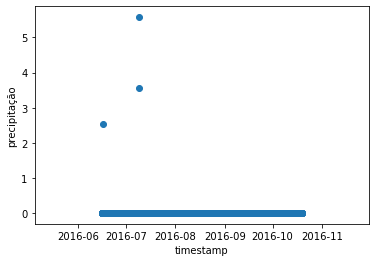

In [59]:
plt.scatter(df_filtered_data.index, df_filtered_data['Rain_mm_Tot'])
plt.xlabel('timestamp')
plt.ylabel('precipitação')
plt.show()

In [60]:
df_filtered_data = df_filtered_data[df_filtered_data['Rain_mm_Tot'] <= 1]
df_filtered_data.shape

(3008, 16)

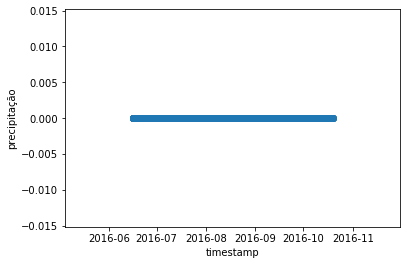

In [61]:
plt.scatter(df_filtered_data.index, df_filtered_data['Rain_mm_Tot'])
plt.xlabel('timestamp')
plt.ylabel('precipitação')
plt.show()

### Velocidade do vento

Para essa feature, vamos remover todos os valores (```WS_ms_Avg```) maiores do que 4.

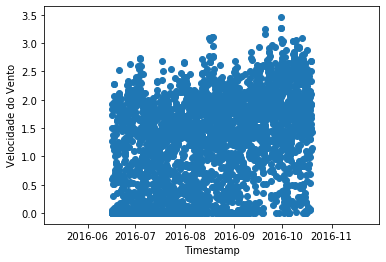

In [62]:
plt.scatter(df_filtered_data.index, df_filtered_data['WS_ms_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Velocidade do Vento')
plt.show()

In [63]:
# Removendo os dados inconsistente velocidade do vento
df_filtered_data = df_filtered_data[df_filtered_data['WS_ms_Avg'] <=4]
df_filtered_data.shape

(3008, 16)

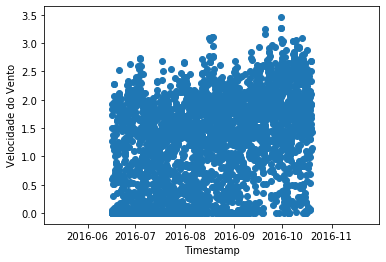

In [65]:
plt.scatter(df_filtered_data.index, df_filtered_data['WS_ms_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Velocidade do Vento')
plt.show()

### Pressão atmosférica máxima

Para essa feature, vamos remover todos os valores (```BP_mbar_Max```) maiores do que 625.

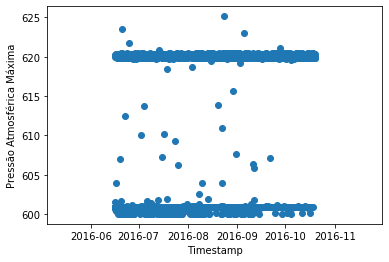

In [67]:
plt.scatter(df_filtered_data.index, df_filtered_data['BP_mbar_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Pressão Atmosférica Máxima')
plt.show()

In [68]:
# Removendo os dados inconsistente da Pressão atmosférica máxima
df_filtered_data = df_filtered_data[df_filtered_data['BP_mbar_Max'] <= 625]
df_filtered_data.shape

(3007, 16)

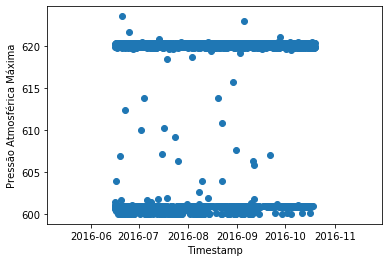

In [69]:
plt.scatter(df_filtered_data.index, df_filtered_data['BP_mbar_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Pressão Atmosférica Máxima')
plt.show()

### Radiação Solar Média

Para essa feature, vamos remover todos os valores (```BP_mbar_Max```) maiores do que 25.4809.

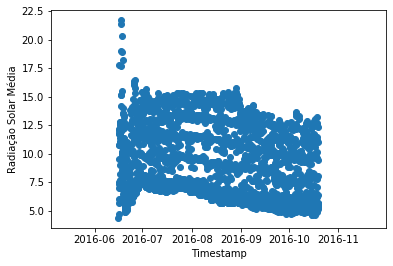

In [70]:
plt.scatter(df_filtered_data.index, df_filtered_data['SlrkJ_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Radiação Solar Média')
plt.show()

In [10]:
# Removendo os dados inconsistente da Radiação solar média
df_filtered_data = df_filtered_data[df_filtered_data['SlrkJ_Avg'] <= 25.4809]
df_filtered_data.shape

(3007, 17)

In [11]:
df_filtered_data['SlrkJ_Tot'].max()

7807.995

In [12]:
# Removendo os dados inconsistente da Radiação solar total
df_filtered_data = df_filtered_data[df_filtered_data['SlrkJ_Tot'] <= 6000000]
df_filtered_data.shape

(3007, 17)

In [13]:
df_filtered_data['TdC_Min'].max()

22.81481

In [14]:
# Removendo os dados inconsistente da Temperatura mínima
df_filtered_data = df_filtered_data[df_filtered_data['TdC_Min'] <= 23.4105]
df_filtered_data.shape

(3007, 17)

In [15]:
df_filtered_data['RH_Avg'].max()

99.10529

In [16]:
# Removendo os dados inconsistente da Umidade relativa média
df_filtered_data = df_filtered_data[df_filtered_data['RH_Avg'] <= 99.8006]
df_filtered_data.shape

(3007, 17)

In [17]:
df_filtered_data['TdC_Max'].max()

24.43459

In [18]:
# Removendo os dados inconsistente da Temperatura máxima
df_filtered_data = df_filtered_data[df_filtered_data['TdC_Max'] <= 24.8820]
df_filtered_data.shape

(3007, 17)

In [19]:
df_filtered_data['AirTC_Min'].max()

36.691

In [20]:
# Removendo os dados inconsistente da Temperatura do ar mínima
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Min'] >= 1]
df_filtered_data.shape

(3007, 17)

In [21]:
# Removendo os dados inconsistente da Temperatura do ar mínima
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Min'] <= 36.692]
df_filtered_data.shape

(3007, 17)

In [22]:
df_filtered_data['AirTC_Max'].max()

23993.0

In [23]:
# Removendo os dados inconsistente da Temperatura do ar maxima
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Max'] >= 1]

In [24]:
#Nenhum dado removido
df_filtered_data.shape

(3007, 17)

In [25]:
# Removendo os dados inconsistente da Temperatura do ar maxima
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Max'] <= 37.965]

In [26]:
df_filtered_data.shape

(3006, 17)

In [27]:
df_filtered_data['RH_Min'].min()

6.96

In [28]:
# Removendo os dados inconsistente da Umidade relativa mínima
df_filtered_data = df_filtered_data[df_filtered_data['RH_Min'] <= 87.062]

In [29]:
df_filtered_data.shape

(2692, 17)

In [30]:
df_filtered_data['RH_Max'].max()

98.13600000000001

In [31]:
# Removendo os dados inconsistente da Umidade relativa maxima
df_filtered_data = df_filtered_data[df_filtered_data['RH_Max'] <= 95.5]

In [32]:
# Fim da remoçaõ dos dados iconsitente
df_filtered_data.shape

(2684, 17)

In [34]:
df_filtered_data = df_filtered_data.reset_index(drop=True)

In [77]:
df_filtered_data

,RECORD,BP_mbar_Max,BP_mbar_Min,Rain_mm_Tot,AirTC_Max,AirTC_Min,RH_Max,RH_Min,SlrkJ_Tot,TdC_Max,TdC_Min,AirTC_Avg,RH_Avg,WS_ms_Avg,SlrkJ_Avg,Eto
TIMESTAMP,,,,,,,,,,,,,,,,
2016-06-16 01:00:00,20609,600.9829,600.2259,0.0,24.434,23.682,89.355,85.546,1585.170,22.29312,21.44312,23.96824,88.16695,0.000000,4.403249,0.002147
2016-06-16 02:00:00,20610,600.6807,600.2900,0.0,23.884,22.529,93.378,88.430,1698.799,21.99075,21.14937,23.08900,91.31065,0.000000,4.718886,0.002250
2016-06-16 03:00:00,20611,600.8853,600.2015,0.0,22.540,21.736,95.656,92.988,2056.785,21.44775,20.88272,22.14371,94.30690,0.000000,5.713292,0.002620
2016-06-16 04:00:00,20612,600.9280,600.6990,0.0,22.158,21.235,96.186,94.537,2190.182,21.41695,20.61035,21.58857,95.49109,0.000000,6.083838,0.002748
2016-06-16 05:00:00,20613,600.9432,600.2564,0.0,21.676,20.823,98.484,95.962,2517.170,21.38091,20.30221,21.12033,96.97942,0.000000,6.992139,0.003087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-19 07:00:00,23615,620.3572,599.7344,0.0,24.954,23.260,85.775,78.117,2295.128,21.04261,20.69714,24.03117,82.42256,1.119167,6.375355,0.023606
2016-10-19 08:00:00,23616,619.8627,599.7466,0.0,27.388,24.835,78.472,65.828,2914.724,21.13052,20.18818,26.09203,72.45580,1.931736,8.096457,0.056306
2016-10-19 09:00:00,23617,619.9329,599.7344,0.0,29.270,27.078,66.904,57.888,3410.409,20.85625,20.01264,28.27324,62.41462,1.920209,9.473359,0.078555


In [74]:
import math

train_percentage = 0.7
linha_fim_treino = math.floor(train_percentage * df_filtered_data.shape[0])
linha_fim_teste = df_filtered_data.shape[0]
df_filtered_data.iloc[0:linha_fim_treino].to_csv('../dados/train.csv')
df_filtered_data.iloc[linha_fim_treino:linha_fim_teste].to_csv('../dados/test.csv')

## Criação de modelos e testes

In [71]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16 LTS; OpenJDK Runtime Environment Zulu11.2+3 (build 11.0.1+13-LTS); OpenJDK 64-Bit Server VM Zulu11.2+3 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /Users/gustavolgcr/miniconda3/envs/mdm2020/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/cs/4b2lpnsn6dg59p2_y72j05jh0000gn/T/tmp0x163vgx
  JVM stdout: /var/folders/cs/4b2lpnsn6dg59p2_y72j05jh0000gn/T/tmp0x163vgx/h2o_gustavolgcr_started_from_python.out
  JVM stderr: /var/folders/cs/4b2lpnsn6dg59p2_y72j05jh0000gn/T/tmp0x163vgx/h2o_gustavolgcr_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Fortaleza
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,11 months and 11 days !!!
H2O cluster name:,H2O_from_python_gustavolgcr_kfqfjf
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [75]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("../dados/train.csv")
test = h2o.import_file("../dados/test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [78]:
x = train.columns
y = "Eto"
x.remove(y)

In [82]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [83]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200418_154055,1.15286e-05,0.00339538,1.15286e-05,0.00223508,0.00317191
StackedEnsemble_BestOfFamily_AutoML_20200418_154055,1.15286e-05,0.00339538,1.15286e-05,0.00223508,0.00317191
XGBoost_1_AutoML_20200418_154055,1.45922e-05,0.00381997,1.45922e-05,0.00283297,0.00360064
XGBoost_2_AutoML_20200418_154055,0.00352281,0.0593533,0.00352281,0.0577344,0.0554773


In [84]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20200418_154055
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3.7085057300699687e-06
RMSE: 0.0019257480962135128
MAE: 0.0012990660661533883
RMSLE: 0.0018197788483098848
R^2: 0.998678852513583
Mean Residual Deviance: 3.7085057300699687e-06
Null degrees of freedom: 2103
Residual degrees of freedom: 2102
Null deviance: 5.90599924405776
Residual deviance: 0.007802696056067214
AIC: -20333.377392768707

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1.1528607267358343e-05
RMSE: 0.0033953802831727616
MAE: 0.002235083544097707
RMSLE: 0.0031719101776477724
R^2: 0.9958929575355217
Mean Residual Deviance: 1.1528607267358343e-05
Null degrees of freedom: 2103
Residual degrees of freedom: 2102
Null deviance: 5.907152772846434
Residual deviance: 0.024256189690521953
AIC: -17947.015316783